In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    # returns mse, and optimal weights
    # ***************************************************
    ws = np.linalg.inv(tx.transpose()@tx)@tx.transpose()@y
    e = y - tx@ws
    mse = 0.5 * e@e / len(y)
    return mse, ws

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
from helpers import *
from grid_search import *
from gradient_descent import *
import datetime

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    # ***************************************************
    ### Grid search ###
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=80)
    # Start the grid search
    start_time = datetime.datetime.now()
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    # Select the best combinaison
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    # Print the results
    print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))
    
    ### Gradient Descent ###
    start_time = datetime.datetime.now()
    gradient_losses, gradient_ws = gradient_descent(y, tx, [0, 0], 15, 0.7, False)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    # Print the results
    print("Gradient Descent: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=gradient_losses[-1], w0=gradient_ws[-1][0], w1=gradient_ws[-1][1], t=execution_time))
    
    ### Least squares ###
    start_time = datetime.datetime.now()
    mse, ws = least_squares(y, tx)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    # Print the results
    print("Least Square: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=mse, w0=ws[0], w1=ws[1], t=execution_time))

Test it here

In [4]:
test_your_least_squares()

Grid Search: loss*=16.369192864348356, w0*=74.68354430379745, w1*=13.291139240506311, execution time=0.282 seconds
Gradient Descent: loss*=15.385887868835754, w0*=73.29392095041752, w1*=13.479712241569908, execution time=0.002 seconds
Least Square: loss*=15.385887868829398, w0*=73.29392200210519, w1*=13.479712434989061, execution time=0.001 seconds


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # polynomial basis function
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    poly_x = np.zeros((len(x), degree+1))
    for j in range (degree+1):
        poly_x[:,j] = x**j
    return poly_x

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from plots import *
from costs import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)
    
    for ind, degree in enumerate(degrees):
        # ***************************************************
        # form the data to do polynomial regression.
        # ***************************************************
        poly_x = build_poly(x, degree)
        # ***************************************************
        # least square and calculate RMSE
        # ***************************************************
        mse, weights = least_squares(y, poly_x)
        rmse = np.sqrt(2*mse)
        
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.2496587036090753
Processing 4th experiment, degree=12, rmse=0.9268294526468844


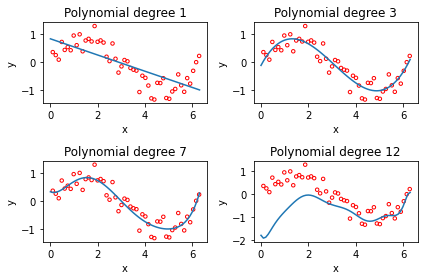

In [8]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [9]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # split the data based on the given ratio
    # ***************************************************
    idx = int(ratio*len(y))
    x_tr = x[:idx]
    y_tr = y[:idx]
    x_te = x[idx:]
    y_te = y[idx:]
    return x_tr, y_tr, x_te, y_te

Then, test your `split_data` function below.

In [10]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    # ***************************************************
    # form train and test data with polynomial basis function
    # ***************************************************
    poly_x_tr = build_poly(x_tr, degree)
    poly_x_te = build_poly(x_te, degree)
    # ***************************************************
    # calculate weight through least square
    # ***************************************************
    mse_tr, ws = least_squares(y_tr, poly_x_tr)
    # ***************************************************
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    # ***************************************************
    rmse_tr = np.sqrt(2*mse_tr)
    rmse_te = np.sqrt(2*compute_loss(y_te, poly_x_te, ws))
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [11]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.488, Testing RMSE=0.296
proportion=0.9, degree=3, Training RMSE=0.266, Testing RMSE=0.194
proportion=0.9, degree=7, Training RMSE=0.257, Testing RMSE=0.186
proportion=0.9, degree=12, Training RMSE=0.268, Testing RMSE=0.186
proportion=0.5, degree=1, Training RMSE=0.458, Testing RMSE=0.547
proportion=0.5, degree=3, Training RMSE=0.261, Testing RMSE=0.267
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.313
proportion=0.5, degree=12, Training RMSE=0.593, Testing RMSE=0.644
proportion=0.1, degree=1, Training RMSE=0.597, Testing RMSE=0.497
proportion=0.1, degree=3, Training RMSE=0.027, Testing RMSE=0.447
proportion=0.1, degree=7, Training RMSE=2.582, Testing RMSE=3.062
proportion=0.1, degree=12, Training RMSE=15.034, Testing RMSE=156334.224


# 3 Ridge Regression
Please fill in the function below.

In [12]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # ***************************************************
    # ridge regression
    # ***************************************************
    lambda_t = 2*len(y)*lambda_
    ws = np.linalg.inv(tx.transpose()@tx + lambda_t*np.identity(tx.shape[1]))@tx.transpose()@y
    e = y - tx@ws
    mse = 0.5 * e@e / len(y)
    return mse, ws

In [13]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    # ***************************************************
    # form train and test data with polynomial basis function
    # ***************************************************
    poly_x_tr = build_poly(x_tr, degree)
    poly_x_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # ridge regression with a given lambda
        # ***************************************************
        mse, ws = ridge_regression(y_tr, poly_x_tr, lambda_)
        rmse_tr.append(np.sqrt(2*mse))
        rmse_te.append(np.sqrt(2*compute_loss(y_te, poly_x_te, ws)))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.233, Testing RMSE=0.303
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.235, Testing RMSE=0.296
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.238, Testing RMSE=0.288
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.242, Testing RMSE=0.282
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.245, Testing RMSE=0.279
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.247, Testing RMSE=0.277
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.248, Testing RMSE=0.275
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.249, Testing RMSE=0.274
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.250, Testing RMSE=0.272
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.251, Testing RMSE=0.269
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.256, Testing RMSE=0.266
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.268, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.193, 

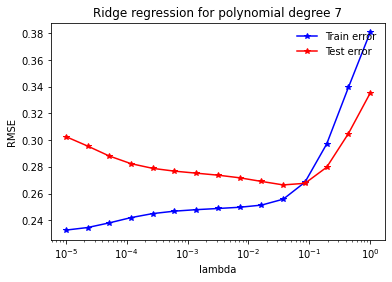

In [14]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)